In [1]:
%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer

In [2]:
# create mesh objects
dim = 2
meshX = 64
meshY = 64
elementMesh = uw.mesh.FeMesh_Cartesian('Q2/dQ1', (meshX,meshY), (0.,0.), (1.,1.))

velocityMesh = elementMesh
pressureMesh = elementMesh.subMesh 

In [3]:
velocityField = uw.mesh.MeshVariable(velocityMesh,2)
velocityField.data[:] = (0.,0.)

In [4]:
pressureField = uw.mesh.MeshVariable(pressureMesh,1)
pressureField.data[:] = 0.

In [5]:
# setup freeslip
# Initialise data.. Note that we are also setting boundary conditions here
solExact = fn.analytic.SolDB2d()
vel=solExact.fn_velocity
velocityField.data[:] = vel.evaluate(velocityMesh.data)
pressureField.data[:] = 0.


In [6]:
# setup analytic functions
solA = fn.analytic.SolDB2d()


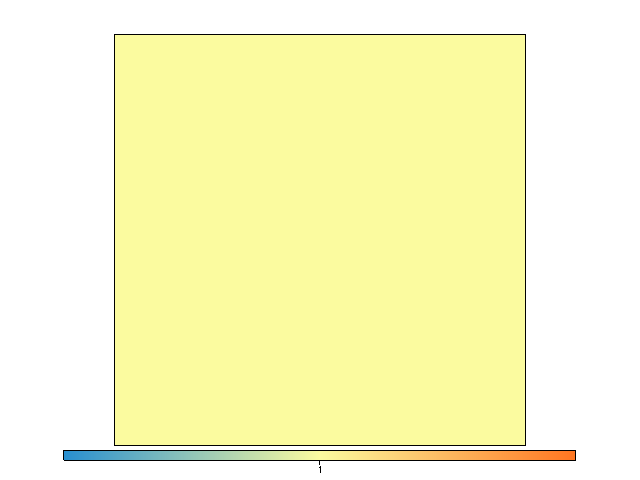

In [7]:
# get eta function from solA and take a look
eta = glucifer.Figure()
eta.append (glucifer.objects.Surface(velocityMesh, solA.fn_viscosity))
eta.show()


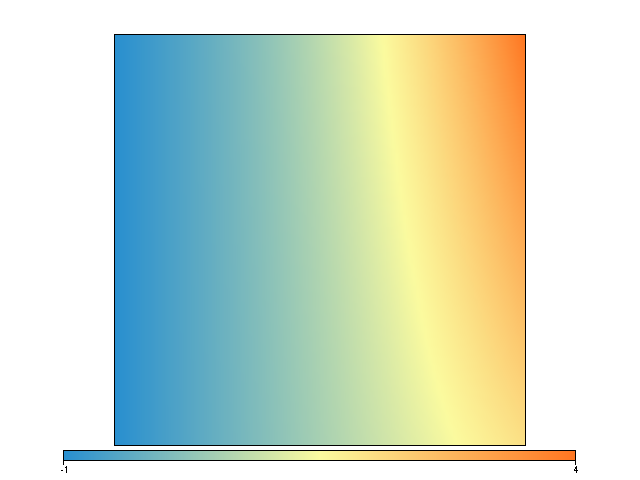

In [8]:
# grab the body force from SolA and take a look at vertical component
force = glucifer.Figure()
force.append (glucifer.objects.Surface(velocityMesh, solA.fn_bodyforce[1]))
force.show()

In [9]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = velocityMesh.specialSets["MinI_VertexSet"] + velocityMesh.specialSets["MaxI_VertexSet"]
JWalls = velocityMesh.specialSets["MinJ_VertexSet"] + velocityMesh.specialSets["MaxJ_VertexSet"]
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
BC = uw.conditions.DirichletCondition( variable=velocityField, 
                                              indexSetsPerDof=(IWalls+JWalls,IWalls+JWalls) )


In [10]:
# setup our stokes guy
stokesSystem = uw.systems.Stokes(velocityField,
                                 pressureField,
                                 solA.fn_viscosity,
                                 solA.fn_bodyforce,
                                 conditions=[BC,])
#, rtolerance=1.e-5)
solver = uw.systems.Solver(stokesSystem)
solver.options.scr.ksp_rtol = 1.e-5 
#solver.set_inner_method(solve_type="lu")

In [11]:
# lets solve
solver.solve()

In [12]:
#errMesh=uw.mesh.FeMesh_Cartesian('Q1', (64,64), (0.,0.), (1.,1.))


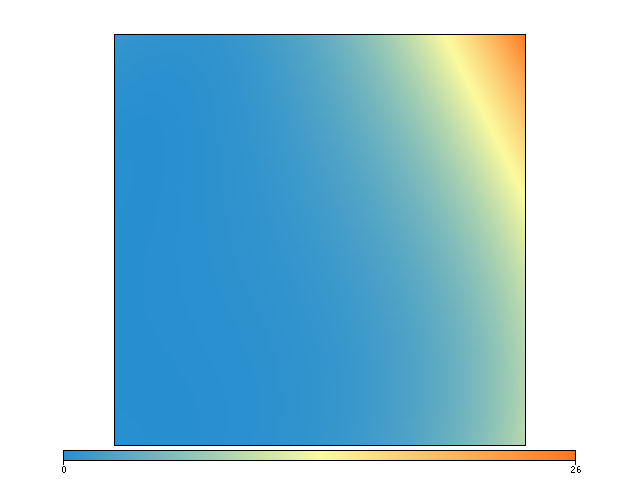

In [13]:
# lets check FEM solution
velMag = glucifer.Figure()
velMag.append (glucifer.objects.Surface(velocityMesh, fn.math.dot(velocityField,velocityField)))
velMag.show()


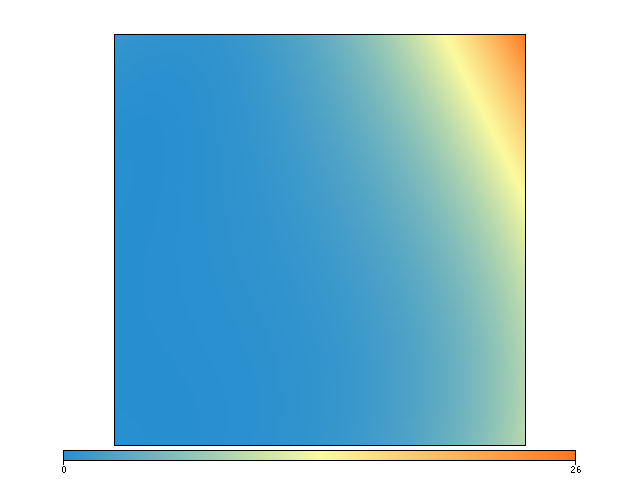

In [14]:
# and analytic
velMagA = glucifer.Figure()
velMagA.append ( glucifer.objects.Surface(velocityMesh, fn.math.dot(solA.fn_velocity,solA.fn_velocity)))
velMagA.show()


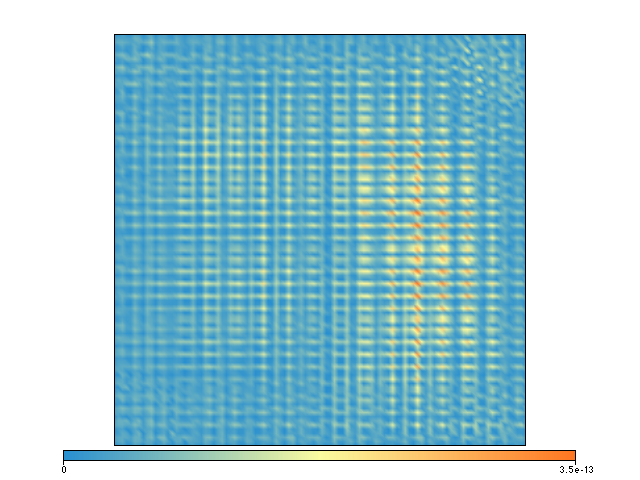

In [15]:
# and difference
velDiff = glucifer.Figure()
velDiff.append (glucifer.objects.Surface(velocityMesh, fn.math.dot(solA.fn_velocity - velocityField,solA.fn_velocity - velocityField)))
velDiff.show()

In [16]:
# rms
squared = uw.utils.Integral(fn.math.dot(solA.fn_velocity-velocityField,solA.fn_velocity-velocityField), velocityMesh)
area = uw.utils.Integral(1.,velocityMesh)
math.sqrt(squared.evaluate()[0]/area.evaluate()[0])

2.29115120651275e-07

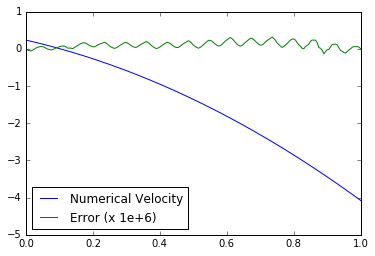

In [17]:
import numpy as np
N=201
a=np.ndarray(shape=(N,2))
a[:,1]=0.75*np.ones(N)
a[:,0]=np.linspace(0,1,N)
import matplotlib.pyplot as mplt
import matplotlib.pylab as pylab
vy=solA.fn_velocity[1].evaluate(a)[:,0]
ax=a[:,0]
vf=velocityField[1].evaluate(a)[:,0]
mplt.plot(ax,vf,label='Numerical Velocity')
#mplt.plot(ax,vy,label='Exact Velocity')
mplt.plot(ax,1e6*(vy-vf),label='Error (x 1e+6)')
mplt.legend(loc=3)


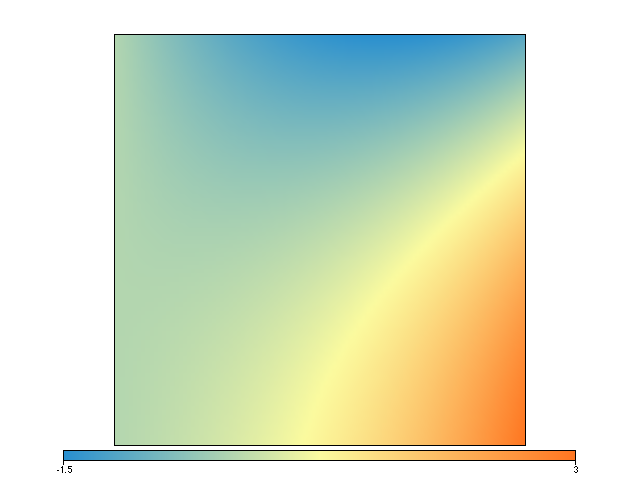

In [18]:
velx = glucifer.Figure()
velx.append ( glucifer.objects.Surface(velocityMesh, solA.fn_velocity[0]))
velx.show()


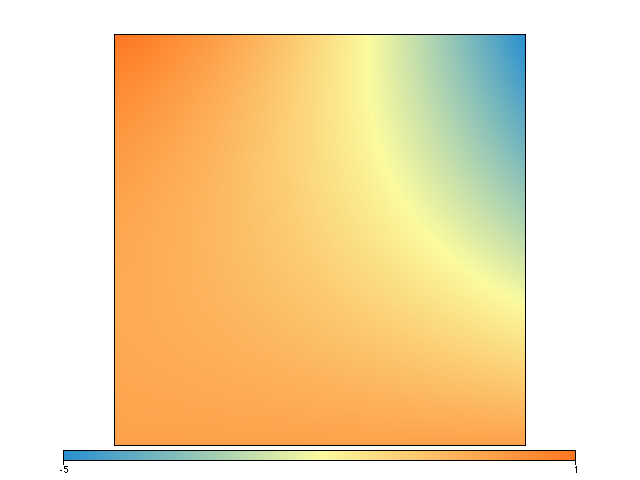

In [19]:
velz = glucifer.Figure()
velz.append ( glucifer.objects.Surface(velocityMesh, solA.fn_velocity[1]))
velz.show()


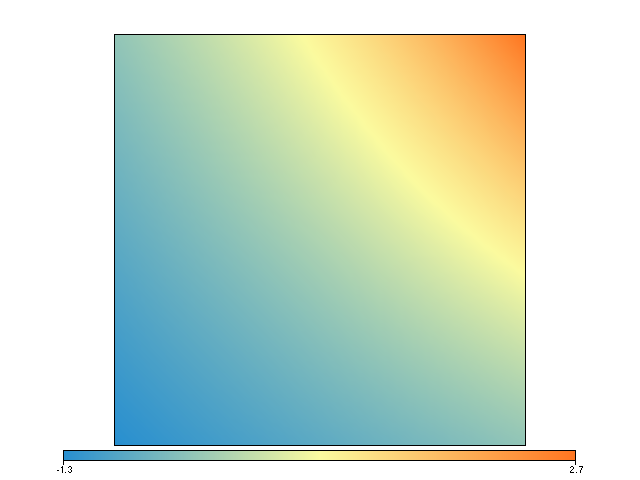

In [20]:
# lets check FEM solution
p = glucifer.Figure()
p.append (glucifer.objects.Surface(velocityMesh, pressureField))
p.show()


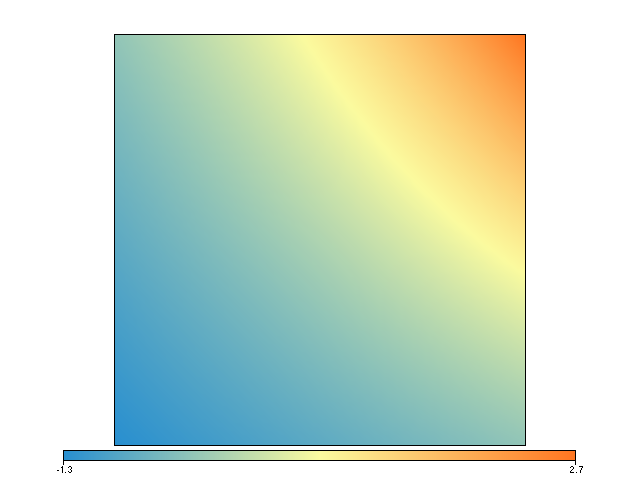

In [21]:
# and analytic
solA=solExact
pA = glucifer.Figure()
pA.append ( glucifer.objects.Surface(velocityMesh, solA.fn_pressure))
pA.show()


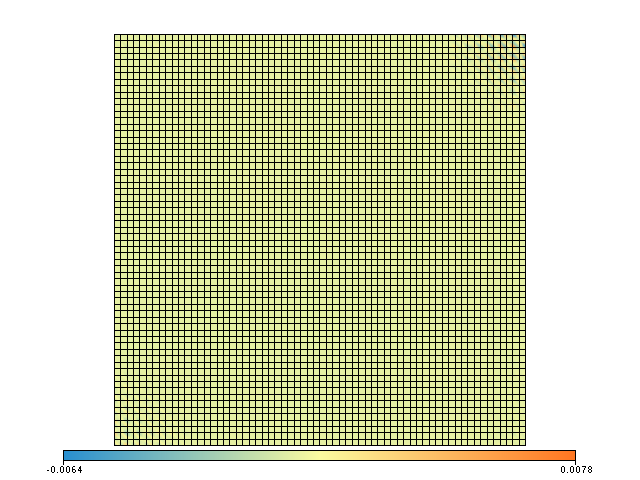

In [22]:
pDiff = glucifer.Figure()
pDiff.append ( glucifer.objects.Surface(velocityMesh, solA.fn_pressure-pressureField))
pDiff.append ( glucifer.objects.Mesh(velocityMesh))
pDiff.show()

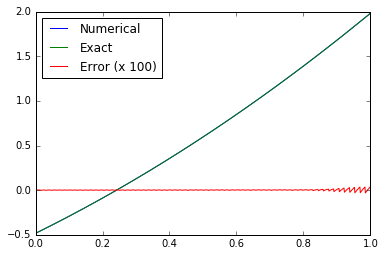

In [23]:
N=801
a=np.ndarray(shape=(N,2))
a[:,0]=0.85*np.ones(N)
a[:,1]=np.linspace(0,1,N)
ax=a[:,1]
pex=solA.fn_pressure.evaluate(a)[:,0]
y=a[:,1]
pfd=pressureField.evaluate(a)[:,0]
mplt.plot(y,pfd,label='Numerical')
mplt.plot(y,pex,label='Exact')
mplt.plot(y,100*(pfd-pex),label='Error (x 100)')
#mplt.xlim(0.492,0.496)
#mplt.ylim(-600,-500)
mplt.legend(loc=2)